#### Libraries

In [1]:
# base
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from datetime import datetime

# file management
import os
import cv2

# data preprosessing
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

# network layers
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# pretrained models
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.densenet import DenseNet121
from keras.applications.nasnet import NASNetMobile

# plots
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## 1. Loading data

In [2]:
# Defining number of categories and image resolution
label_categories = 10
img_size = 224
batch_size = 32

In [3]:
# 1.1 FUNCTIONS FOR DATA PREPARATION

# Function for navigating the data folder
def data_prep(data_dir, img_resolution, n_categories = 0):
    
    # Data directory
    parent_folder = os.path.expanduser(data_dir)
    
    # Get names of folders(classes)
    class_names = os.listdir(parent_folder) 
    if n_categories>1:
        class_names = random.sample(class_names, n_categories)
        
    # prepare data
    X_images, Y_labels = training_data(parent_folder, class_names, img_resolution)
    return X_images, Y_labels, class_names

# Function for extracting images from folder
def training_data(parent_folder, class_names, img_resolution):
    
    # Empty output
    X_images = []
    Y_labels = []
    
    # Iterate through each folder
    for image_folder in class_names:
        
        # Extracting labels and specifying path
        label = label_assignment(image_folder)
        data_dir = parent_folder+"/"+image_folder
        
        # Iterate through images in folder
        for image_name in tqdm(os.listdir(data_dir)):
            
            # setting path to image
            path = os.path.join(data_dir, image_name)
            
            # image conversion           
            img = cv2.imread(path) # read image
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # set color
            img_array = Image.fromarray(img, 'RGB') # Convert to RGB format
            resized_img = img_array.resize((img_resolution, img_resolution)) # resize image to match network input

            # appending the original image to output
            X_images.append(np.array(resized_img))
            Y_labels.append(str(label)) 
    
    return X_images, Y_labels
        
# Function for correcting labels
def label_assignment(input):
    name = str(input)
    label = '_'.join(name.split("-")[1:]).title()
    return label

In [4]:
# 1.2 EXTRACTING IMAGES

# Empty output
random_seed = 42

# Loading data
images, labels, class_names = data_prep(data_dir = 'data/images/', img_resolution=img_size, n_categories = label_categories)
print("No. of images loaded: ", len(images),
      "\nNo. of labels loaded: ", len(labels),
      "\nSelected breeds: ", class_names)

100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 62.56it/s]

No. of images loaded:  1660 
No. of labels loaded:  1660 
Selected breeds:  ['n02108915-French_bulldog', 'n02113978-Mexican_hairless', 'n02105412-kelpie', 'n02089078-black-and-tan_coonhound', 'n02086240-Shih-Tzu', 'n02097658-silky_terrier', 'n02106166-Border_collie', 'n02090379-redbone', 'n02097130-giant_schnauzer', 'n02091032-Italian_greyhound']


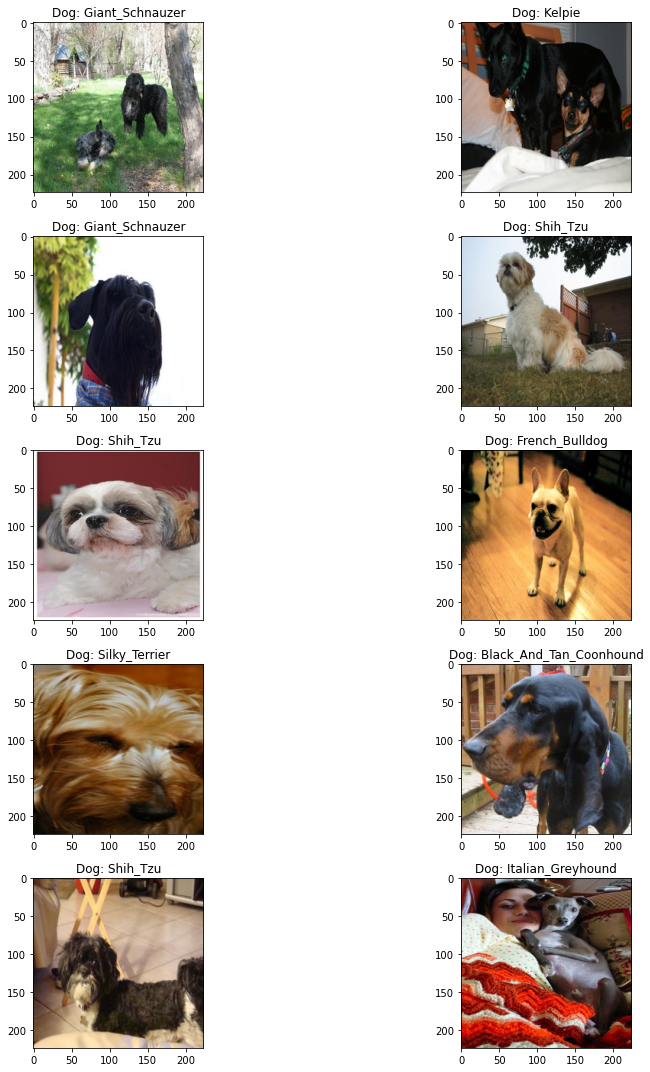

In [5]:
# 1.3 GET SOME IMAGES

fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=random.randint(0,len(labels))
        ax[i,j].imshow(images[l])
        ax[i,j].set_title('Dog: '+labels[l])
plt.tight_layout()

## 2. Data prep

In [6]:
# 2.1 ADJUSTING THE DATA TYPES

# Encoding categories as numbers
label_encoder = LabelEncoder()
labels_int = label_encoder.fit_transform(labels)

# Converting lists
X_data = np.array(images)
Y_data = np.array(labels_int)
print("Images shape = ", X_data.shape,
      "\nLabels shape = ", Y_data.shape)
print(type(X_data), type(Y_data))

Images shape =  (1660, 224, 224, 3) 
Labels shape =  (1660,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [7]:
# 2.2 SHUFFLE THE DATA

n = np.arange(X_data.shape[0])
np.random.seed(random_seed)
np.random.shuffle(n)
X_data = X_data[n]
Y_data = Y_data[n]
print("Images shape after shuffling = ", X_data.shape,
      "\nLabels shape after shuffling = ", Y_data.shape)

Images shape after shuffling =  (1660, 224, 224, 3) 
Labels shape after shuffling =  (1660,)


In [8]:
# 2.3 NORMALISE THE DATA

X_data = X_data.astype(np.float32)
Y_data = Y_data.astype(np.int32)
X_data = X_data/255
print("Images shape after normalization = ", X_data.shape)

Images shape after normalization =  (1660, 224, 224, 3)


In [9]:
# 2.4 SAVE THE PREPARED DATA

with open('data/X_data_{}.npy'.format(label_categories), 'wb') as f:
    np.save(f, X_data)
with open('data/Y_data_{}.npy'.format(label_categories), 'wb') as f:
    np.save(f, Y_data)

In [10]:
# 2.5 LOAD THE PREPARED DATA

X_data = np.load('data/X_data_{}.npy'.format(label_categories))
Y_data = np.load('data/Y_data_{}.npy'.format(label_categories))

In [11]:
# 2.4 SPLIT THE DATA INTO TRAIN/TEST

X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.3, random_state=69)
print("X_train shape = ", X_train.shape)
print("Y_train shape = ", Y_train.shape)
print("X_test shape = ", X_test.shape)
print("Y_test shape = ", Y_test.shape)

X_train shape =  (1162, 224, 224, 3)
Y_train shape =  (1162,)
X_test shape =  (498, 224, 224, 3)
Y_test shape =  (498,)


## 3. Models

Source: https://machinelearningmastery.com/review-of-architectural-innovations-for-convolutional-neural-networks-for-image-classification/

In [12]:
# 3.1 PREPARE FUNCTIONS FOR PLOTTING

# Training history plot
def history_plot(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    
    ax[0].set_title('Loss')
    ax[0].plot(history.index, history["loss"], label="Train")
    ax[0].plot(history.index, history["val_loss"], label="Validation")
    ax[0].legend()
    
    ax[1].set_title('Accuracy')
    ax[1].plot(history.index, history["accuracy"], label="Train")
    ax[1].plot(history.index, history["val_accuracy"], label="Validation")
    ax[1].legend()

# Plot of some predictions
def predicted_images(prediction):
    plt.figure(1 , figsize = (19 , 10))
    n = 0 
    labels_txt = label_encoder.inverse_transform(Y_test) 
    for i in range(9):
        n += 1 
        r = np.random.randint( 0, X_test.shape[0], 1)
        plt.subplot(3, 3, n)
        plt.subplots_adjust(hspace = 0.4, wspace = 0.3)
        plt.imshow(X_test[r[0]])

        class_label = labels_txt[r[0]]
        class_actual = Y_test[r[0]]
        class_pred = Y_test[r[0]]*prediction[r[0]][Y_test[r[0]]]

        plt.title('Name = {}, \nActual_class = {}, \nPredicted_class = {}'.format(class_label, class_actual, class_pred),
                                                                                  loc='left')
        plt.xticks([]) , plt.yticks([])
    plt.show()

In [13]:
# 3.2 ADD RESTRICTIONS TO AVOID OVERFITTING

# Reduce learning rate if model does not improve
reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,
                           patience=3, verbose=1, 
                           mode='max', min_delta=0.00001)

# Adding an early stopper
early = EarlyStopping(monitor='val_accuracy', min_delta=0, 
                      patience=12, verbose=1,
                      mode='max', baseline = 0.01)

callbacks = [reduce, early]

## 4. AlexNet CNN

In [14]:
# 4.1 PREPARE THE MODEL STRUCTURE

model_alexnet = Sequential()
#1 conv layer
model_alexnet.add(Conv2D(filters=96, kernel_size=(11,11), strides=(4,4),
                         padding="valid", activation="relu", input_shape=(img_size,img_size,3)))
#2 max pool layer
model_alexnet.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
model_alexnet.add(BatchNormalization())
#3 conv layer
model_alexnet.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1),
                         padding="valid", activation="relu"))
#4 max pool layer
model_alexnet.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
model_alexnet.add(BatchNormalization())
#5 conv layer
model_alexnet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1),
                         padding="valid", activation="relu"))
#6 conv layer
model_alexnet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1),
                         padding="valid", activation="relu"))
#7 conv layer
model_alexnet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1),
                         padding="valid", activation="relu"))
#8 max pool layer
model_alexnet.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
model_alexnet.add(BatchNormalization())
model_alexnet.add(Flatten())
#9 dense layer
model_alexnet.add(Dense(4096, input_shape=(img_size,img_size,3),
                        activation="relu"))
model_alexnet.add(Dropout(0.4))
model_alexnet.add(BatchNormalization())
#10 dense layer
model_alexnet.add(Dense(4096, activation="relu"))
model_alexnet.add(Dropout(0.4))
model_alexnet.add(BatchNormalization())
#11 dense layer
model_alexnet.add(Dense(1000, activation="relu"))
model_alexnet.add(Dropout(0.4))
model_alexnet.add(BatchNormalization())
#12 output layer
model_alexnet.add(Dense(label_categories, activation="softmax"))
model_alexnet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 54, 54, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 26, 26, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 96)        384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 256)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 10, 256)       1024      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 384)         8

In [15]:
# 4.2 TRAIN THE MODEL 

# Compile
model_alexnet.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train 
start_time = datetime.now()
history_alexnet = model_alexnet.fit(X_train, Y_train,
                                    validation_data = (X_test, Y_test),
                                    epochs = 100, 
                                    batch_size = batch_size,
                                    validation_batch_size = batch_size,
                                    callbacks = callbacks)
end_time = datetime.now()
alexnet_time = end_time - start_time
print('Total time taken: ', str(alexnet_time))

Epoch 1/100
37/37 [==============================] - 53s 1s/step - loss: 3.2353 - accuracy: 0.1564 - val_loss: 31.5184 - val_accuracy: 0.0823
Epoch 2/100
37/37 [==============================] - 50s 1s/step - loss: 2.7020 - accuracy: 0.1693 - val_loss: 8.3695 - val_accuracy: 0.1084
Epoch 3/100
37/37 [==============================] - 50s 1s/step - loss: 2.3809 - accuracy: 0.2374 - val_loss: 3.0603 - val_accuracy: 0.1426
Epoch 4/100
37/37 [==============================] - 51s 1s/step - loss: 2.3651 - accuracy: 0.2173 - val_loss: 2.4094 - val_accuracy: 0.1546
Epoch 5/100
37/37 [==============================] - 50s 1s/step - loss: 2.3568 - accuracy: 0.2034 - val_loss: 2.4927 - val_accuracy: 0.1767
Epoch 6/100
37/37 [==============================] - 51s 1s/step - loss: 2.2668 - accuracy: 0.2422 - val_loss: 2.3515 - val_accuracy: 0.1867
Epoch 7/100
37/37 [==============================] - 50s 1s/step - loss: 2.1860 - accuracy: 0.2554 - val_loss: 2.3604 - val_accuracy: 0.2028
Epoch 8/100


In [16]:
# 4.3 SAVE MODEL AND HISTORY

# Model
model_alexnet.save('models/alexnet', overwrite=True)

# History
history_alexnet_df = pd.DataFrame(history_alexnet.history) 
with open('models/history_alexnet.csv', mode='w') as f:
    history_alexnet_df.to_csv(f, sep = ';')

INFO:tensorflow:Assets written to: models/alexnet\assets


In [17]:
# 4.4 LOAD MODEL AND HISTORY

# Model
model_alexnet = load_model('models/alexnet')

# History
history_alexnet = pd.read_csv('models/history_alexnet.csv', sep = ';')

16/16 [==============================] - 5s 266ms/step - loss: 2.0954 - accuracy: 0.3574
Alexnet accuracy:  0.35742971301078796 
Alexnet loss:  2.095400810241699


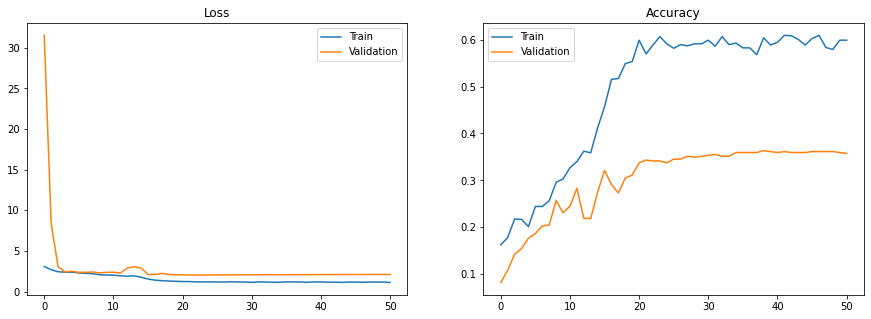

In [18]:
# 4.5 EVALUATE THE MODEL 

# Model evaluation 
loss_alexnet, accuracy_alexnet = model_alexnet.evaluate(X_test, Y_test)
print("Alexnet accuracy: ", accuracy_alexnet,
      "\nAlexnet loss: ", loss_alexnet)

# results visualisation
history_plot(history_alexnet)

(498, 10)


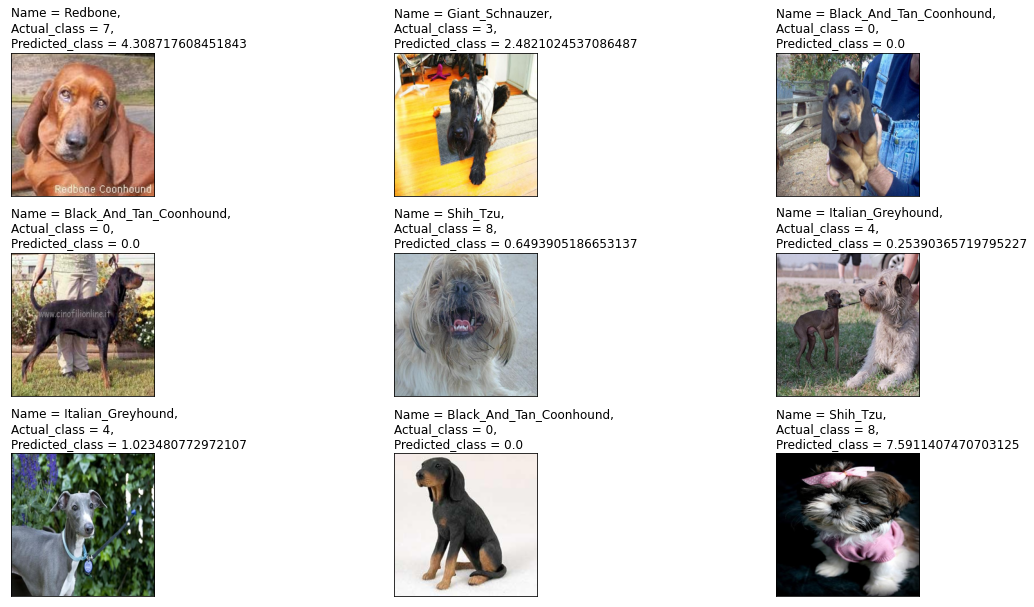

In [19]:
# 4.6 MAKE PREDICTION

# Prediction 
pred_alexnet = model_alexnet.predict(X_test)
print(pred_alexnet.shape)

# Prediction visualisation
predicted_images(pred_alexnet)

## 5. ResNet50

NOTE: While the following 3 models can be implemented manually (as shown in the other notebook), their training time per epoch is ~17 min. In order to speed up the process, I will use a pre-trained model and retrain only the last layers via transfer learning. 

In [20]:
# 5.1 PREPARE THE MODEL STRUCTURE
# base model
base_model_resnet = ResNet50(weights='imagenet', 
                             include_top=False, 
                             input_shape=(img_size,img_size,3))

# final model
model_resnet = Sequential()
model_resnet.add(base_model_resnet)
model_resnet.add(GlobalAveragePooling2D())
model_resnet.add(Dense(1024, activation="relu"))
model_resnet.add(Dropout(0.5))
model_resnet.add(Dense(1024, activation="relu"))
model_resnet.add(Dropout(0.5))
model_resnet.add(Dense(label_categories, activation= 'softmax'))

# retrain only the last (added) layers
for layer in model_resnet.layers[:-6]:
    layer.trainable = False

model_resnet.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)               

In [21]:
# 5.2 TRAIN THE MODEL 

# Compile
model_resnet.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train 
start_time = datetime.now()
history_resnet = model_resnet.fit(X_train, Y_train,
                                  validation_data = (X_test, Y_test),
                                  epochs = 100, 
                                  batch_size = batch_size,
                                  validation_batch_size = batch_size,
                                  callbacks = callbacks)
end_time = datetime.now()
resnet_time = end_time - start_time
print('Total time taken: ', str(resnet_time))

Epoch 1/100
37/37 [==============================] - 148s 4s/step - loss: 2.7131 - accuracy: 0.0968 - val_loss: 2.3101 - val_accuracy: 0.0944
Epoch 2/100
37/37 [==============================] - 142s 4s/step - loss: 2.3436 - accuracy: 0.1038 - val_loss: 2.3104 - val_accuracy: 0.1165
Epoch 3/100
37/37 [==============================] - 142s 4s/step - loss: 2.3224 - accuracy: 0.1160 - val_loss: 2.3123 - val_accuracy: 0.1165
Epoch 4/100
37/37 [==============================] - 142s 4s/step - loss: 2.3156 - accuracy: 0.1077 - val_loss: 2.3055 - val_accuracy: 0.1265
Epoch 5/100
37/37 [==============================] - 142s 4s/step - loss: 2.2941 - accuracy: 0.1361 - val_loss: 2.3027 - val_accuracy: 0.1064
Epoch 6/100
37/37 [==============================] - 142s 4s/step - loss: 2.2998 - accuracy: 0.1207 - val_loss: 2.3009 - val_accuracy: 0.1185
Epoch 7/100
37/37 [==============================] - 145s 4s/step - loss: 2.2911 - accuracy: 0.1596 - val_loss: 2.2972 - val_accuracy: 0.1285
Epoch 

In [22]:
# 5.3 SAVE MODEL AND HISTORY

# Model
model_resnet.save('models/resnet', overwrite=True)

# History
history_resnet_df = pd.DataFrame(history_resnet.history) 
with open('models/history_resnet.csv', mode='w') as f:
    history_resnet_df.to_csv(f, sep = ';')

INFO:tensorflow:Assets written to: models/resnet\assets


In [23]:
# 5.4 LOAD MODEL AND HISTORY

# Model
model_resnet = load_model('models/resnet')

# History
history_resnet = pd.read_csv('models/history_resnet.csv', sep = ';')

16/16 [==============================] - 43s 3s/step - loss: 2.2902 - accuracy: 0.1225
Resnet accuracy:  0.12248995900154114 
Resnet loss:  2.290242910385132


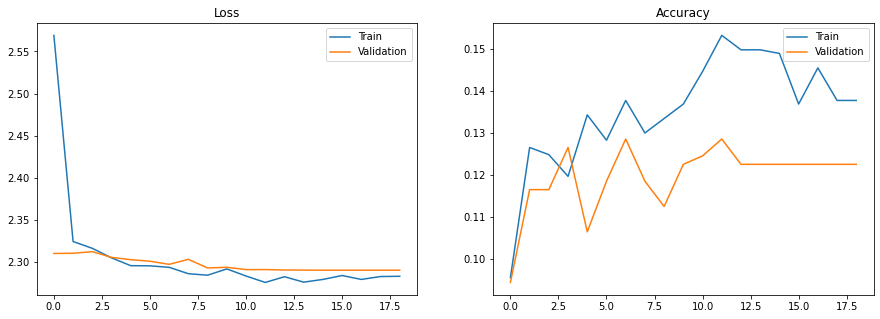

In [24]:
# 5.5 EVALUATE THE MODEL

# Model evaluation 
loss_resnet, accuracy_resnet = model_resnet.evaluate(X_test, Y_test)
print("Resnet accuracy: ", accuracy_resnet,
      "\nResnet loss: ", loss_resnet)

# results visualisation
history_plot(history_resnet)

(498, 10)


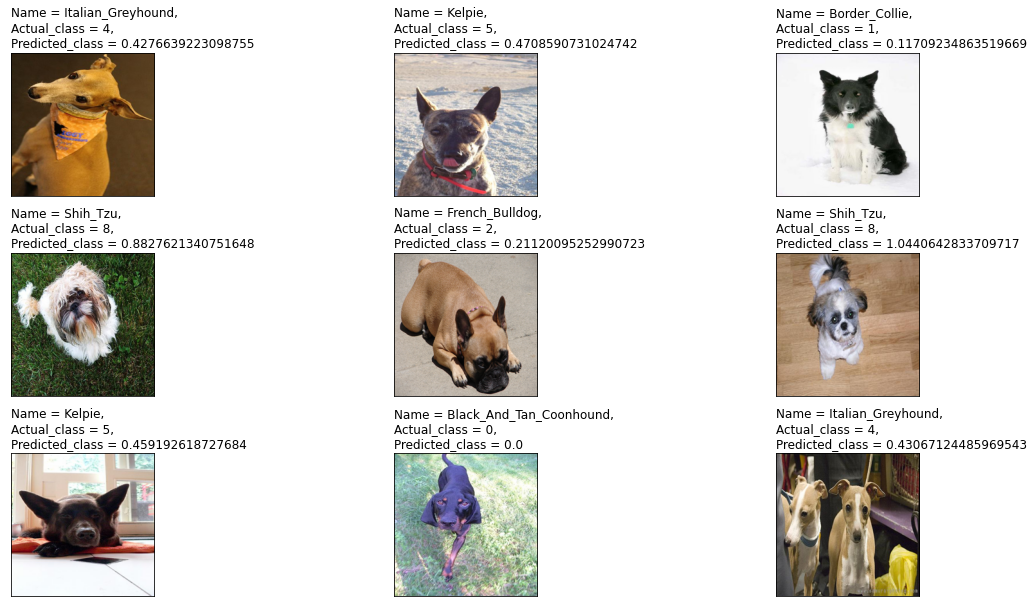

In [25]:
# 5.6 MAKE PREDICTION

# Prediction 
pred_resnet = model_resnet.predict(X_test)
print(pred_resnet.shape)

# Prediction visualisation
predicted_images(pred_resnet)

## 6. VGG16

In [26]:
# 6.1 PREPARE THE MODEL STRUCTURE

# base model
base_model_vgg16 = VGG16(weights='imagenet', 
                         include_top=False, 
                         input_shape=(img_size,img_size,3))

# final model
model_vgg16 = Sequential()
model_vgg16.add(base_model_vgg16)
model_vgg16.add(GlobalAveragePooling2D())
model_vgg16.add(Dense(1024, activation="relu"))
model_vgg16.add(Dropout(0.5))
model_vgg16.add(Dense(1024, activation="relu"))
model_vgg16.add(Dropout(0.5))
model_vgg16.add(Dense(label_categories, activation= 'softmax'))

# retrain only the last (added) layers
for layer in model_vgg16.layers[:-6]:
    layer.trainable = False
                
model_vgg16.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)               

In [27]:
# 6.2 TRAIN THE MODEL 

# Compile
model_vgg16.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train 
start_time = datetime.now()
history_vgg16 = model_vgg16.fit(X_train, Y_train,
                                validation_data = (X_test, Y_test),
                                epochs = 100, 
                                batch_size = batch_size,
                                validation_batch_size = batch_size,
                                callbacks = callbacks)
end_time = datetime.now()
vgg16_time = end_time - start_time
print('Total time taken: ', str(vgg16_time))

Epoch 1/100
37/37 [==============================] - 359s 10s/step - loss: 2.4591 - accuracy: 0.1317 - val_loss: 2.0379 - val_accuracy: 0.2470
Epoch 2/100
37/37 [==============================] - 374s 10s/step - loss: 2.0040 - accuracy: 0.2551 - val_loss: 1.7237 - val_accuracy: 0.4157
Epoch 3/100
37/37 [==============================] - 355s 10s/step - loss: 1.6917 - accuracy: 0.3941 - val_loss: 1.5180 - val_accuracy: 0.4659
Epoch 4/100
37/37 [==============================] - 357s 10s/step - loss: 1.5356 - accuracy: 0.4362 - val_loss: 1.3434 - val_accuracy: 0.5683
Epoch 5/100
37/37 [==============================] - 363s 10s/step - loss: 1.3539 - accuracy: 0.5305 - val_loss: 1.3105 - val_accuracy: 0.5643
Epoch 6/100
37/37 [==============================] - 364s 10s/step - loss: 1.2407 - accuracy: 0.5511 - val_loss: 1.2182 - val_accuracy: 0.5823
Epoch 7/100
37/37 [==============================] - 356s 10s/step - loss: 1.1625 - accuracy: 0.5863 - val_loss: 1.1120 - val_accuracy: 0.6044

In [28]:
# 6.3 SAVE MODEL AND HISTORY

# Model
model_vgg16.save('models/vgg16', overwrite=True)

# History
history_vgg16_df = pd.DataFrame(history_vgg16.history) 
with open('models/history_vgg16.csv', mode='w') as f:
    history_vgg16_df.to_csv(f, sep = ';')

INFO:tensorflow:Assets written to: models/vgg16\assets


In [29]:
# 6.4 LOAD MODEL AND HISTORY

# Model
model_vgg16 = load_model('models/vgg16')

# History
history_vgg16 = pd.read_csv('models/history_vgg16.csv', sep = ';')

16/16 [==============================] - 112s 7s/step - loss: 0.9065 - accuracy: 0.7048
VGG16 accuracy:  0.7048192620277405 
VGG16 loss:  0.906501293182373


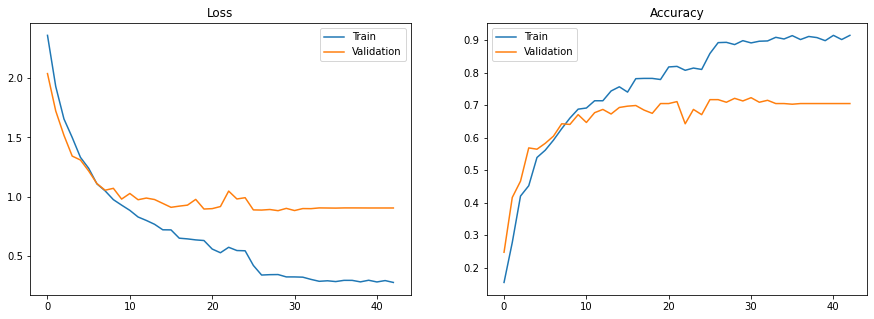

In [30]:
# 6.5 EVALUATE THE MODEL

# Model evaluation 
loss_vgg16, accuracy_vgg16 = model_vgg16.evaluate(X_test, Y_test)
print("VGG16 accuracy: ", accuracy_vgg16,
      "\nVGG16 loss: ", loss_vgg16)

# results visualisation
history_plot(history_vgg16)

(498, 10)


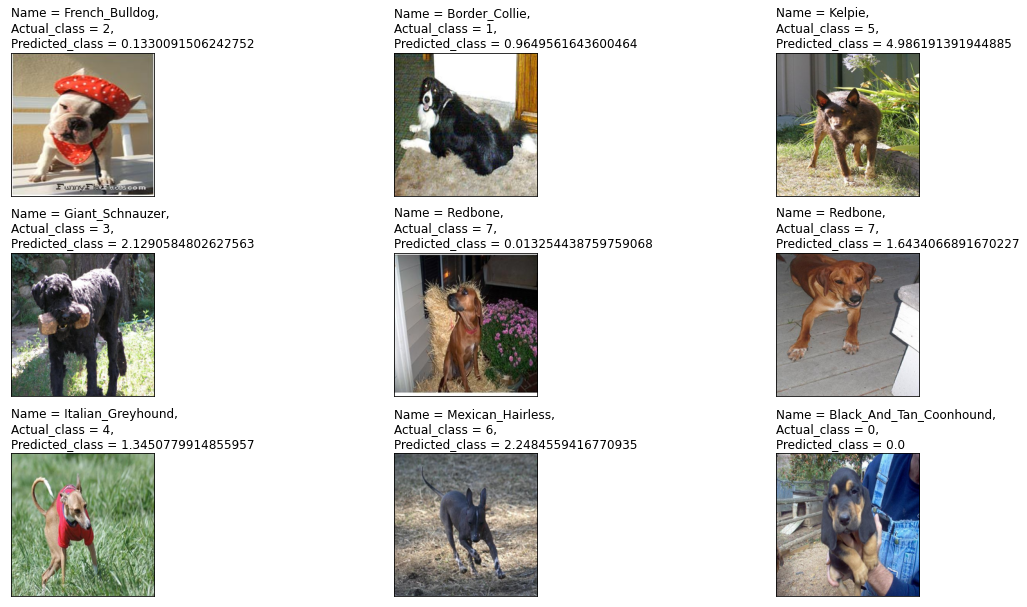

In [31]:
# 6.6 MAKE PREDICTION

# Prediction 
pred_vgg16 = model_vgg16.predict(X_test)
print(pred_vgg16.shape)

# Prediction visualisation
predicted_images(pred_vgg16)

## 7. DenseNet121

In [32]:
# 7.1 PREPARE THE MODEL STRUCTURE

# base model
base_model_densenet = DenseNet121(weights='imagenet', 
                                  include_top=False, 
                                  input_shape=(img_size,img_size,3))

# final model
model_densenet = Sequential()
model_densenet.add(base_model_densenet)
model_densenet.add(GlobalAveragePooling2D())
model_densenet.add(Dense(1024, activation="relu"))
model_densenet.add(Dropout(0.5))
model_densenet.add(Dense(1024, activation="relu"))
model_densenet.add(Dropout(0.5))
model_densenet.add(Dense(label_categories, activation= 'softmax'))

# retrain only the last (added) layers
for layer in model_densenet.layers[:-6]:
    layer.trainable = False
                
model_densenet.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_7 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_8 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)               

In [33]:
# 7.2 TRAIN THE MODEL 

# Compile
model_densenet.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train 
start_time = datetime.now()
history_densenet = model_densenet.fit(X_train, Y_train,
                                      validation_data = (X_test, Y_test),
                                      epochs = 100, 
                                      batch_size = batch_size,
                                      validation_batch_size = batch_size,
                                      callbacks = callbacks)
end_time = datetime.now()
densenet_time = end_time - start_time
print('Total time taken: ', str(densenet_time))

Epoch 1/100
37/37 [==============================] - 161s 4s/step - loss: 1.5453 - accuracy: 0.4977 - val_loss: 0.4577 - val_accuracy: 0.8373
Epoch 2/100
37/37 [==============================] - 152s 4s/step - loss: 0.4209 - accuracy: 0.8711 - val_loss: 0.1920 - val_accuracy: 0.9398
Epoch 3/100
37/37 [==============================] - 153s 4s/step - loss: 0.2178 - accuracy: 0.9390 - val_loss: 0.1428 - val_accuracy: 0.9538
Epoch 4/100
37/37 [==============================] - 152s 4s/step - loss: 0.2563 - accuracy: 0.9190 - val_loss: 0.1576 - val_accuracy: 0.9458
Epoch 5/100
37/37 [==============================] - 160s 4s/step - loss: 0.1946 - accuracy: 0.9419 - val_loss: 0.1782 - val_accuracy: 0.9418
Epoch 6/100
37/37 [==============================] - 153s 4s/step - loss: 0.1306 - accuracy: 0.9544 - val_loss: 0.1883 - val_accuracy: 0.9378

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/100
37/37 [==============================] - 150s 4s/step 

In [34]:
# 7.3 SAVE MODEL AND HISTORY

# Model
model_densenet.save('models/densenet', overwrite=True)

# History
history_densenet_df = pd.DataFrame(history_densenet.history) 
with open('models/history_densenet.csv', mode='w') as f:
    history_densenet_df.to_csv(f, sep = ';')

INFO:tensorflow:Assets written to: models/densenet\assets


In [35]:
# 7.4 LOAD MODEL AND HISTORY

# Model
model_densenet = load_model('models/densenet')

# History
history_densenet = pd.read_csv('models/history_densenet.csv', sep = ';')

16/16 [==============================] - 157s 10s/step - loss: 0.1148 - accuracy: 0.9618
Densenet accuracy:  0.9618473649024963 
Densenet loss:  0.11480523645877838


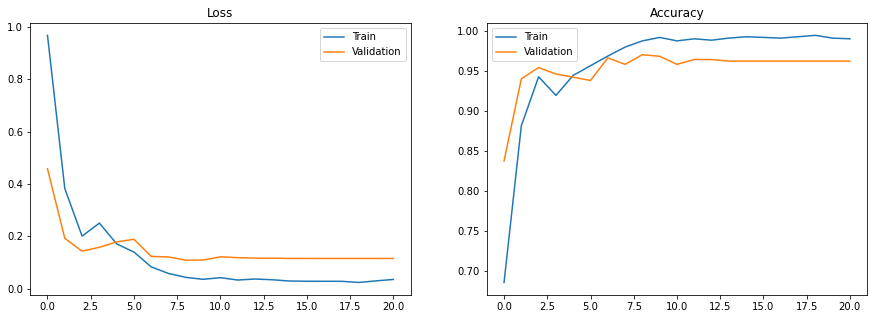

In [36]:
# 7.5 EVALUATE THE MODEL

# Model evaluation 
loss_densenet, accuracy_densenet = model_densenet.evaluate(X_test, Y_test)
print("Densenet accuracy: ", accuracy_densenet,
      "\nDensenet loss: ", loss_densenet)

# results visualisation
history_plot(history_densenet)

(498, 10)


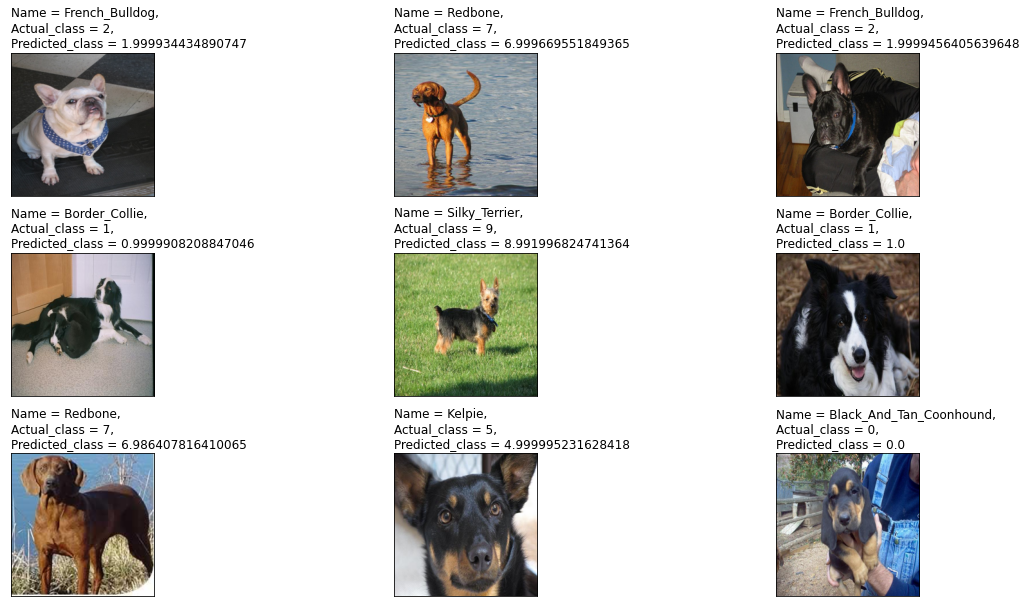

In [37]:
# 7.6 MAKE PREDICTION

# Prediction 
pred_densenet = model_densenet.predict(X_test)
print(pred_densenet.shape)

# Prediction visualisation
predicted_images(pred_densenet)

## 8. NasNetMobile

In [38]:
# 8.1 PREPARE THE MODEL STRUCTURE

# base model
base_model_nasnet = NASNetMobile(weights='imagenet', 
                                 include_top=False, 
                                 input_shape=(img_size,img_size,3))

# final model
model_nasnet = Sequential()
model_nasnet.add(base_model_nasnet)
model_nasnet.add(GlobalAveragePooling2D())
model_nasnet.add(Dense(1024, activation="relu"))
model_nasnet.add(Dropout(0.5))
model_nasnet.add(Dense(1024, activation="relu"))
model_nasnet.add(Dropout(0.5))
model_nasnet.add(Dense(label_categories, activation= 'softmax'))

# retrain only the last (added) layers
for layer in model_nasnet.layers[:-6]:
    layer.trainable = False
                
model_nasnet.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Functional)          (None, 7, 7, 1056)        4269716   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1056)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 1024)              1082368   
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_10 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 10)               

In [39]:
# 8.2 TRAIN THE MODEL 

# Compile
model_nasnet.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train 
start_time = datetime.now()
history_nasnet = model_nasnet.fit(X_train, Y_train,
                                  validation_data = (X_test, Y_test),
                                  epochs = 100, 
                                  batch_size = batch_size,
                                  validation_batch_size = batch_size,
                                  callbacks = callbacks)
end_time = datetime.now()
nasnet_time = end_time - start_time
print('Total time taken: ', str(nasnet_time))

Epoch 1/100
37/37 [==============================] - 118s 3s/step - loss: 0.9162 - accuracy: 0.7288 - val_loss: 0.1001 - val_accuracy: 0.9739
Epoch 2/100
37/37 [==============================] - 96s 3s/step - loss: 0.1398 - accuracy: 0.9614 - val_loss: 0.1047 - val_accuracy: 0.9659
Epoch 3/100
37/37 [==============================] - 97s 3s/step - loss: 0.0874 - accuracy: 0.9714 - val_loss: 0.1045 - val_accuracy: 0.9779
Epoch 4/100
37/37 [==============================] - 95s 3s/step - loss: 0.0398 - accuracy: 0.9863 - val_loss: 0.1122 - val_accuracy: 0.9739
Epoch 5/100
37/37 [==============================] - 96s 3s/step - loss: 0.1389 - accuracy: 0.9636 - val_loss: 0.1460 - val_accuracy: 0.9679
Epoch 6/100
37/37 [==============================] - 96s 3s/step - loss: 0.0551 - accuracy: 0.9858 - val_loss: 0.1146 - val_accuracy: 0.9699

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/100
37/37 [==============================] - 95s 3s/step - loss

In [40]:
# 8.3 SAVE MODEL AND HISTORY

# Model
model_nasnet.save('models/nasnet', overwrite=True)

# History
history_nasnet_df = pd.DataFrame(history_nasnet.history) 
with open('models/history_nasnet.csv', mode='w') as f:
    history_nasnet_df.to_csv(f, sep = ';')

INFO:tensorflow:Assets written to: models/nasnet\assets


In [41]:
# 8.4 LOAD MODEL AND HISTORY

# Model
model_nasnet = load_model('models/nasnet')

# History
history_nasnet = pd.read_csv('models/history_nasnet.csv', sep = ';')

16/16 [==============================] - 36s 2s/step - loss: 0.0982 - accuracy: 0.9839
Nasnet accuracy:  0.9839357137680054 
Nasnet loss:  0.11480523645877838


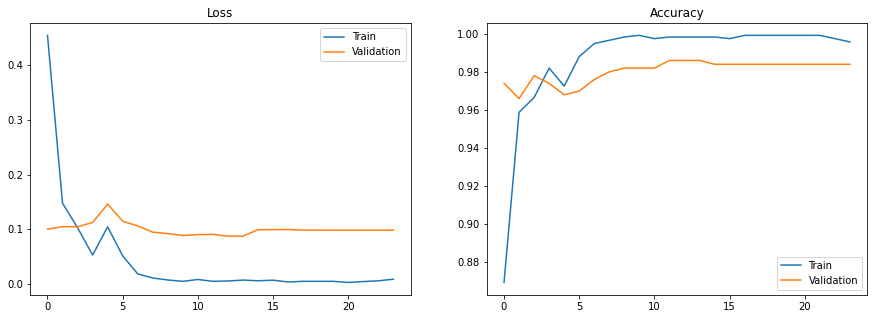

In [42]:
# 8.5 EVALUATE THE MODEL

# Model evaluation 
loss_nasnet, accuracy_nasnet = model_nasnet.evaluate(X_test, Y_test)
print("Nasnet accuracy: ", accuracy_nasnet,
      "\nNasnet loss: ", loss_nasnet)

# results visualisation
history_plot(history_nasnet)

(498, 10)


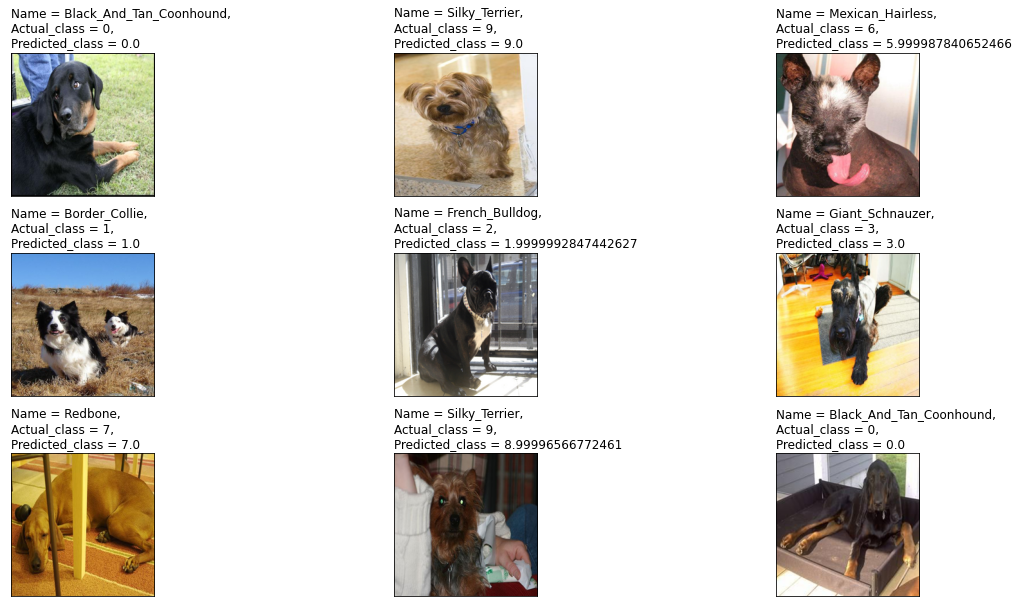

In [43]:
# 8.6 MAKE PREDICTION

# Prediction 
pred_nasnet = model_nasnet.predict(X_test)
print(pred_nasnet.shape)

# Prediction visualisation
predicted_images(pred_nasnet)

## 9. Final results

In [54]:
Model = ['AlexNet', 'ResNet', 'VGG16', 'DenseNet', 'NasNet']
Losses = [loss_alexnet, loss_resnet, loss_vgg16, loss_densenet, loss_nasnet]
Accuracy = [accuracy_alexnet, accuracy_resnet, accuracy_vgg16, accuracy_densenet, accuracy_nasnet]
Times = [str(alexnet_time), str(resnet_time), str(vgg16_time), str(densenet_time), str(nasnet_time)]
df = pd.DataFrame(data = {"Model name": Model,
                          "Validation Loss": Losses,
                          "Validation Accuracy": Accuracy,
                          "Time": Times})
df.Time = df.Time.str[:7]
df.head()

,Model name,Validation Loss,Validation Accuracy,Time
0,AlexNet,2.095401,0.357430,0:42:18
1,ResNet,2.290243,0.122490,0:45:40
2,VGG16,0.906501,0.704819,4:16:48
3,DenseNet,0.114805,0.961847,0:53:09
4,NasNet,0.098185,0.983936,0:38:45
